In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv("training_data.csv")
y = df["increase_stock"].map({
    "low_bike_demand": 0,
    "high_bike_demand": 1
})
X = df.drop(columns=["increase_stock"])



X = df[["windspeed", "snowdepth", "cloudcover"]]

In [2]:
def standardize(X):
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    std[std == 0] = 1  # prevent division by zero
    return (X - mean) / std, mean, std


X_scaled, mean, std = standardize(X)


In [3]:
from collections import Counter

def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))


def knn_predict(X_train, y_train, x_test, k=5):
    distances = []

    for i in range(len(X_train)):
        dist = euclidean_distance(X_train[i], x_test)
        distances.append((dist, y_train[i]))

    distances.sort(key=lambda x: x[0])

    k_nearest = [label for _, label in distances[:k]]

    return Counter(k_nearest).most_common(1)[0][0]


In [4]:
x_new = X.sample(n=1)

x_new_scaled = (x_new - mean) / std

pred = knn_predict(X_scaled.values, y.values, x_new_scaled.values, k=5)

print("Prediction:", "high_bike_demand" if pred == 1 else "low_bike_demand")


Prediction: low_bike_demand


Prediction: low_bike_demand


/Users/tlindberg/Desktop/smask/.venv/lib/python3.9/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/tlindberg/Desktop/smask/.venv/lib/python3.9/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/tlindberg/Desktop/smask/.venv/lib/python3.9/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T


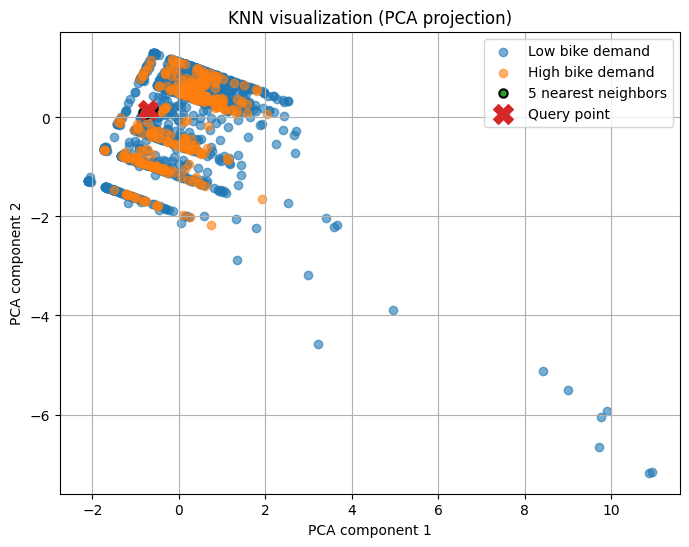

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def project_to_2d(X_df):
    """
    X_df: pandas DataFrame (scaled)
    """
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X_df)
    return X_2d, pca

def visualize_knn(X_train, y_train, x_test, k=5):
    """
    X_train: scaled DataFrame
    y_train: Series
    x_test: scaled DataFrame (1 row)
    """

    # ---- PCA projection ----
    X_2d, pca = project_to_2d(X_train)
    x_test_2d = pca.transform(x_test)

    # ---- Compute distances ----
    distances = []
    for i in range(len(X_train)):
        dist = euclidean_distance(X_train.iloc[i], x_test.iloc[0])
        distances.append((dist, i))

    distances.sort(key=lambda x: x[0])
    neighbor_idx = [i for _, i in distances[:k]]

    # ---- Plot ----
    plt.figure(figsize=(8, 6))

    # Training points
    plt.scatter(
        X_2d[y_train == 0, 0],
        X_2d[y_train == 0, 1],
        label="Low bike demand",
        alpha=0.6
    )

    plt.scatter(
        X_2d[y_train == 1, 0],
        X_2d[y_train == 1, 1],
        label="High bike demand",
        alpha=0.6
    )

    # Nearest neighbors
    plt.scatter(
        X_2d[neighbor_idx, 0],
        X_2d[neighbor_idx, 1],
        edgecolors="black",
        linewidths=1.5,
        label=f"{k} nearest neighbors"
    )

    # Test point
    plt.scatter(
        x_test_2d[0, 0],
        x_test_2d[0, 1],
        marker="X",
        s=200,
        label="Query point"
    )

    plt.title("KNN visualization (PCA projection)")
    plt.xlabel("PCA component 1")
    plt.ylabel("PCA component 2")
    plt.legend()
    plt.grid(True)
    plt.show()


# Scale
mean = X.mean()
std = X.std().replace(0, 1)

X_scaled = (X - mean) / std

# Random test point
x_new = X.sample(n=1)
x_new_scaled = (x_new - mean) / std

# Predict
pred = knn_predict(X_scaled.values, y.values, x_new_scaled.values, k=5)

print("Prediction:", "high_bike_demand" if pred == 1 else "low_bike_demand")

# Visualize
visualize_knn(X_scaled, y, x_new_scaled, k=5)


In [6]:
X_scaled.values

array([[ 0.41480526, -0.10140728, -0.99919099],
       [ 1.39460946, -0.10140728,  0.65277445],
       [-1.6866169 , -0.10140728,  0.51231158],
       ...,
       [ 0.65975631,  4.64695814,  0.45734785],
       [-0.93887159, -0.10140728, -1.2190459 ],
       [ 1.13676625, -0.10140728,  1.01003869]])

In [7]:
y

0       0
1       0
2       0
3       0
4       0
       ..
1595    0
1596    0
1597    0
1598    1
1599    0
Name: increase_stock, Length: 1600, dtype: int64

In [8]:
X_scaled

,windspeed,snowdepth,cloudcover
0,0.414805,-0.101407,-0.999191
1,1.394609,-0.101407,0.652774
2,-1.686617,-0.101407,0.512312
3,0.788678,-0.101407,-1.964110
4,-0.332940,-0.101407,-0.602231
...,...,...,...
1595,-0.320048,-0.101407,-1.219046
1596,-0.423185,-0.101407,0.848201
1597,0.659756,4.646958,0.457348
1598,-0.938872,-0.101407,-1.219046


In [9]:
x_new_scaled

,windspeed,snowdepth,cloudcover
532,-0.938872,-0.101407,-0.095343


In [10]:

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [12]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [13]:
model = LogisticRegression(
    max_iter=1000,
    solver="lbfgs"
)

model.fit(X_train_scaled, y_train)


/Users/tlindberg/Desktop/smask/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/tlindberg/Desktop/smask/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/tlindberg/Desktop/smask/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept


LogisticRegression(max_iter=1000)

In [14]:
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]


In [16]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.81875

Confusion Matrix:
[[262   0]
 [ 58   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       262
           1       0.00      0.00      0.00        58

    accuracy                           0.82       320
   macro avg       0.41      0.50      0.45       320
weighted avg       0.67      0.82      0.74       320



/Users/tlindberg/Desktop/smask/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tlindberg/Desktop/smask/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tlindberg/Desktop/smask/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita